In [0]:
def calculate_loss(gamma, reward, Q_t, Q_next, loss_func):
  """ Method header to calculate the loss.
  NOTE: THIS CODE SNIPPET WILL NOT WORK RIGHT NOW, BUT SHOULD ONCE YOU HAVE
  EVERYTHING ELSE IMPLEMENTED

  Args:
      gamma  (float) : Discount for rewards
      reward (int)   : Reward for action taken
      Q_t    (tensor): Tensor of Q-Values for each action at time t
      Q_next (tensor): Tensor of Q-Values for each action at time t+1
  """
  
  # TODO: Insert your code here
  
  loss_func = torch.nn.MSELoss()
  loss = loss_func(Q_t, (reward + gamma* Q_next))
  return loss

## HAOQI'S ARCHITECTURE

In [0]:
import torch
import torch.nn as nn

class DQNetwork(nn.Module):
    """ Template class for your DQN. Please feel free to modify headers as needed.
    """
    def __init__(self, states, actions): 
      super(DQNetwork, self).__init__()
      
      self.fc1 = torch.nn.Linear(states, 128)
      self.fc2 = torch.nn.Linear(128, actions)

    def forward(self, x):
      
      x = torch.nn.functional.relu(self.fc1(x))
      x = self.fc2(x)

      return x

In [0]:
# Install dependency
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torchvision.datasets import FashionMNIST
from torchvision.transforms import ToTensor
import torch.nn.functional as F
from torch.autograd import Variable
from torchvision.datasets import FashionMNIST 
from torchvision.transforms import ToTensor 
import random
import numpy as np
import matplotlib
import pandas as pd
import dill

In [0]:
# RNN model simulate Q function
# input: Batch_size*timestamp*feature_size
# output: Q value of each action
class RNN_Q_Network(nn.Module):
  # feature_size is the number of feature, in our environment it should be 9
  # hidden_size is the hidden size of LSTM
  # output_size is the number of action. In our case, it should be 2(3)
  # FC_hidden_size is the hidden_size of the fully connected layer
  def __init__(self, feature_size = 9, hidden_size = 256, FC_hidden_size = 256, output_size = 3):
    super(RNN_Q_Network, self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.feature_size = feature_size
    self.FC_hidden_size = FC_hidden_size
 
    self.recurrent = nn.LSTM(self.feature_size, self.hidden_size)
    
    #fully-Connected Layer
    self.fc1 = nn.Linear(self.hidden_size, self.FC_hidden_size)
    self.fc2 = nn.Linear(self.FC_hidden_size, self.output_size)

    self.fc3 = nn.ReLU()

  def forward(self, x):
    # TODO
    outputn, (hidden_n, cell_n) = self.recurrent(x)
    hidden_n = hidden_n.squeeze(0)
    temp_layer = self.fc3(self.fc1(hidden_n))
    Q_val = self.fc2(temp_layer)   
    return Q_val

In [0]:
# RNN model + self attention simulate Q function
# input: Batch_size*timestamp*feature_size
# output: Q value of each action
# Attention model: generate a list of weight
# Follow the discussion in HW#4
class Attention(nn.Module):
  def __init__(self, hidden_size):
    super(Attention, self).__init__()
    self.fc1 = nn.Linear(2*hidden_size, 1)
  # encoder_outputs is the output_n of the LSTM
  def forward(self, hidden, encoder_outputs):
    num = len(encoder_outputs)
    weights = []
    # For each timestamp generate a weight with shape (batch_size)
    for idx, data in enumerate(encoder_outputs):
      weight = self.fc1(torch.cat((data, hidden[0]), dim = 1))

      weights.append(weight.tolist())
    # weights shape(timestamp*batch_size)
    weights = torch.Tensor(weights).squeeze(2)
    weights = torch.transpose(weights, 0 ,1)
    # weights shape(batch_size*timestamp)
    weights = F.softmax(weights, dim = 1)
    return weights

class RNN_Attention_Q_Network(nn.Module):
  # feature_size is the number of feature, in our environment it should be 9
  # hidden_size is the hidden size of LSTM
  # output_size is the number of action. In our case, it should be 2(3)
  # FC_hidden_size is the hidden_size of the fully connected layer
  def __init__(self, feature_size = 9, hidden_size = 256, FC_hidden_size = 1024, output_size = 3):
    super(RNN_Attention_Q_Network, self).__init__()
    self.output_size = output_size
    self.hidden_size = hidden_size
    self.feature_size = feature_size
    self.FC_hidden_size = FC_hidden_size
    self.attention = Attention(self.hidden_size)
 
    self.recurrent = nn.LSTM(self.feature_size, self.hidden_size)
    #fully-Connected Layer
    self.fc1 = nn.Linear(2*self.hidden_size, self.FC_hidden_size)
    self.fc2 = nn.Linear(self.FC_hidden_size, self.output_size)

    self.fc3 = nn.ReLU()

  def forward(self, x):
    x = x[:, :9, :]
    x = x.transpose(1,2)
    x = x.transpose(0,1)
    outputn, (hidden_n, cell_n) = self.recurrent(x)
    # generate the weights
    print(outputn.shape)
    print(hidden_n.shape)
    weights = self.attention.forward(hidden_n, outputn)
    # generate the weights-averaged sequence
    context = torch.bmm(weights.unsqueeze(1), torch.transpose(outputn, 0 ,1))
    context = context.squeeze(1)
    hidden_n = hidden_n.squeeze(0)
    # concatenate context and hidden
    newinput = torch.cat((context,hidden_n), dim = 1)
    # generate Q function
    temp_layer = self.fc3(self.fc1(newinput))
    Q_val = self.fc2(temp_layer)
    return Q_val

In [0]:
# CNN model simulate Q function
# input: Batch_size*timestamp*feature_size
# output: Q value of each action
class CNN_Q_Network(nn.Module):
  # timestamp: the number of input time stamp 
  # feature_size: the numebr of input feature
  # channel_size 1 and 2: the number of channel_size of 2 convolutional layer
  # kernel_size 1 and 2: the number of 2 kernel size of 2 convolutional layer
  # hidden_size: the size of a fully connected hidden layer 
  # output_size: the number of actions
  def __init__(self, timestamp, feature_size, channel_size_1 = 1, channel_size_2 = 1, kernel_size_1 = 3, kernel_size_2 = 3, hidden_size = 256, output_size = 3):
    super(CNN_Q_Network, self).__init__()
    self.timestamp = timestamp
    self.feature_size = feature_size
    self.channel_size_1 = channel_size_1
    self.channel_size_2 = channel_size_2
    self.kernel_size_1 = kernel_size_1
    self.kernel_size_2 = kernel_size_2
    self.hidden_size = hidden_size
    # 2 convolutional layer
    self.features = nn.Sequential(
        nn.Conv2d(1, self.channel_size_1, self.kernel_size_1, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(self.channel_size_1, self.channel_size_2, self.kernel_size_2, stride = 1, padding = 1),
        nn.ReLU()
    )
    # after_CL_feature and after_CL_timestamp mean the "feature size" and "time stamp" after convolutional layer
    self.after_CL_feature = feature_size-kernel_size_1-kernel_size_2+6
    self.after_CL_timestamp = timestamp-kernel_size_1-kernel_size_2+6
    # Q_generator are 2 fully connect layers to generate Q function
    self.Q_generator = nn.Sequential(
        nn.Linear(self.channel_size_2*self.after_CL_feature*self.after_CL_timestamp, self.hidden_size),
        nn.ReLU(),
        nn.Linear(self.hidden_size, output_size)
    )

  def forward(self, x):
    x = x.unsqueeze(1)
    x = self.features(x)
    x = x.view(-1, self.channel_size_2*self.after_CL_feature*self.after_CL_timestamp)
    Q_val = self.Q_generator(x)
    return Q_val


In [0]:
# CNN + RNN model simulate Q function
# input: Batch_size*timestamp*feature_size
# output: Q value of each action
class CNN_RNN_Q_Network(nn.Module):
  # timestamp: the number of input time stamp 
  # feature_size: the numebr of input feature
  # channel_size 1 and 2: the number of channel_size of 2 convolutional layer
  # kernel_size 1 and 2: the number of 2 kernel size of 2 convolutional layer
  # hidden_LSTM: the size of the hidden layer of LSTM
  # hidden_size: the size of a fully connected hidden layer 
  # output_size: the number of actions
  def __init__(self,timestamp, feature_size, channel_size_1 = 1, channel_size_2 = 1, kernel_size_1 = 3, kernel_size_2 = 3, hidden_LSTM = 256, hidden_size = 256, output_size = 3):
    super(CNN_RNN_Q_Network, self).__init__()
    self.timestamp = timestamp
    self.feature_size = feature_size
    self.channel_size_1 = channel_size_1
    self.channel_size_2 = channel_size_2
    self.kernel_size_1 = kernel_size_1
    self.kernel_size_2 = kernel_size_2
    self.hidden_size = hidden_size
    # 2 convolutional layer
    self.features = nn.Sequential(
        nn.Conv2d(1, self.channel_size_1, self.kernel_size_1, stride = 1, padding = 1),
        nn.ReLU(),
        nn.Conv2d(self.channel_size_1, self.channel_size_2, self.kernel_size_2, stride = 1, padding = 1),
        nn.ReLU()
    )
    # after_CL_feature and after_CL_timestamp mean the "feature size" and "time stamp" after convolutional layer
    self.after_CL_feature = feature_size-kernel_size_1-kernel_size_2+6
    self.after_CL_timestamp = timestamp-kernel_size_1-kernel_size_2+6
    # recurrent layer
    self.recurrent = nn.LSTM(self.after_CL_feature*self.channel_size_2, self.hidden_LSTM)
    # Q generator
    self.Q_generator = nn.Sequential(
        nn.Linear(self.hidden_LSTM, self.hidden_size),
        nn.ReLU(),
        nn.Linear(self.hidden_size, self.output_size)
    )

  def forward(self, x):
    x = self.features(x)
    # reshape x to be(time_stamp, batch_size, -1)
    x = torch.transpose(x, 1, 2)
    batch = len(x)
    timestamp = len(x[0])
    x = x.view(batch, timestamp, -1)
    x = torch.transpose(x, 0 ,1)
    # recurrent layer
    outputn, (hidden_n, cell_n) = self.recurrent(x)
    #FC layer
    hidden_n = hidden_n.squeeze(0)
    Q_val = self.Q_generator(x)
    return Q_val

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import random
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math as math

In [0]:
df = pd.read_csv('/content/drive/My Drive/gemini_BTCUSD_2019_10min (1).csv')
label = df["label"]
df.drop(["Unix Timestamp", "Date", "Symbol","open_ma", "high_ma", "low_ma", "open_ea", "low_ea", "high_ea", "label"], axis=1, inplace=True)

In [36]:
df.head

<bound method NDFrame.head of            Open      High       Low  ...     close_ea  close_so  close_stdv
0       5882.70   5886.31   5875.50  ...  5890.410000  1.000000    0.000000
1       5882.47   5888.06   5880.38  ...  5889.008182  1.379278    0.000000
2       5885.00   5890.41   5882.47  ...  5887.819421  0.482897    3.855000
3       5894.20   5894.20   5885.00  ...  5887.306799  0.467471    3.689935
4       5902.78   5902.78   5888.88  ...  5888.560109  0.508021    3.196674
...         ...       ...       ...  ...          ...       ...         ...
604787  3691.21  13850.00  13822.80  ...  3687.889022  0.000208    1.260327
604788  3689.50  13850.00  13823.16  ...  3688.068654  0.000000    1.476496
604789  3689.67  13850.00  13825.52  ...  3688.255808  0.000168    1.635230
604790  3695.00  13858.37  13843.71  ...  3688.418025  0.000000    1.639108
604791  3692.35   3695.00   3692.35  ...  3688.562929  0.000000    1.645371

[604792 rows x 9 columns]>

In [0]:
start = 0
n_test = 20000
n_train = 100000
datapoints = 80000

In [0]:
df = df.iloc[start:start+n_test+n_train]

In [39]:
df.head

<bound method NDFrame.head of           Open     High      Low  ...     close_ea  close_so  close_stdv
0      5882.70  5886.31  5875.50  ...  5890.410000  1.000000    0.000000
1      5882.47  5888.06  5880.38  ...  5889.008182  1.379278    0.000000
2      5885.00  5890.41  5882.47  ...  5887.819421  0.482897    3.855000
3      5894.20  5894.20  5885.00  ...  5887.306799  0.467471    3.689935
4      5902.78  5902.78  5888.88  ...  5888.560109  0.508021    3.196674
...        ...      ...      ...  ...          ...       ...         ...
29995  8744.98  8757.45  8754.95  ...  8743.063827  0.021749    2.858905
29996  8742.87  8754.95  8754.95  ...  8742.484949  0.000000    2.025621
29997  8749.00  8755.00  8754.63  ...  8742.059686  0.180131    2.457239
29998  8749.03  8754.63  8753.89  ...  8741.792834  0.000000    2.505944
29999  8749.00  8753.89  8753.89  ...  8741.767046  0.000000    3.428062

[30000 rows x 9 columns]>

In [0]:
df_test = df.iloc[0:n_test]

In [41]:
df1 = pd.DataFrame({'Open' :df_test['Open'].to_numpy(),'High':df_test['High'].to_numpy(),'Low':df_test['Low'].to_numpy(), 'Close':df_test['Close'].to_numpy(), 'Volume':df_test['Volume'].to_numpy(), 'close_ma':df_test['close_ma'].to_numpy(), 'close_ea':df_test['close_ea'].to_numpy(), 'close_so':df_test['close_so'].to_numpy(), 'close_stdv':df_test['close_stdv'].to_numpy()})
df_test = df1
print(df_test)

          Open     High      Low  ...     close_ea  close_so  close_stdv
0      5882.70  5886.31  5875.50  ...  5890.410000  1.000000    0.000000
1      5882.47  5888.06  5880.38  ...  5889.008182  1.379278    0.000000
2      5885.00  5890.41  5882.47  ...  5887.819421  0.482897    3.855000
3      5894.20  5894.20  5885.00  ...  5887.306799  0.467471    3.689935
4      5902.78  5902.78  5888.88  ...  5888.560109  0.508021    3.196674
...        ...      ...      ...  ...          ...       ...         ...
19995  5175.74  5212.81  5199.07  ...  5179.526907  0.002225    6.009341
19996  5178.81  5213.44  5206.93  ...  5178.435469  0.003091    5.460828
19997  5180.22  5213.44  5191.65  ...  5177.617747  0.000000    5.456202
19998  5188.33  5193.39  5181.74  ...  5177.089975  0.000000    5.540777
19999  5183.41  5192.20  5179.02  ...  5176.820525  0.002846    5.635619

[20000 rows x 9 columns]


In [42]:
df_train = df.iloc[n_test:n_test+n_train]
print(df_train)

          Open     High      Low  ...     close_ea  close_so  close_stdv
20000  5183.36  5184.08  5177.16  ...  5176.915521  0.002753    6.541641
20001  5199.24  5179.48  5173.18  ...  5177.402153  0.000167    3.800581
20002  5208.52  5180.40  5173.18  ...  5177.939944  0.000000    3.707290
20003  5204.39  5180.41  5174.31  ...  5178.808317  0.000000    6.453562
20004  5208.49  5177.04  5176.27  ...  5180.080623  0.002329    9.802453
...        ...      ...      ...  ...          ...       ...         ...
29995  8744.98  8757.45  8754.95  ...  8743.063827  0.021749    2.858905
29996  8742.87  8754.95  8754.95  ...  8742.484949  0.000000    2.025621
29997  8749.00  8755.00  8754.63  ...  8742.059686  0.180131    2.457239
29998  8749.03  8754.63  8753.89  ...  8741.792834  0.000000    2.505944
29999  8749.00  8753.89  8753.89  ...  8741.767046  0.000000    3.428062

[10000 rows x 9 columns]


In [43]:
df2 = pd.DataFrame({'Open' :df_train['Open'].to_numpy(),'High':df_train['High'].to_numpy(),'Low':df_train['Low'].to_numpy(), 'Close':df_train['Close'].to_numpy(), 'Volume':df_train['Volume'].to_numpy(), 'close_ma':df_train['close_ma'].to_numpy(), 'close_ea':df_train['close_ea'].to_numpy(), 'close_so':df_train['close_so'].to_numpy(), 'close_stdv':df_train['close_stdv'].to_numpy()})
df_train = df2
print(df_train)

         Open     High      Low  ...     close_ea  close_so  close_stdv
0     5183.36  5184.08  5177.16  ...  5176.915521  0.002753    6.541641
1     5199.24  5179.48  5173.18  ...  5177.402153  0.000167    3.800581
2     5208.52  5180.40  5173.18  ...  5177.939944  0.000000    3.707290
3     5204.39  5180.41  5174.31  ...  5178.808317  0.000000    6.453562
4     5208.49  5177.04  5176.27  ...  5180.080623  0.002329    9.802453
...       ...      ...      ...  ...          ...       ...         ...
9995  8744.98  8757.45  8754.95  ...  8743.063827  0.021749    2.858905
9996  8742.87  8754.95  8754.95  ...  8742.484949  0.000000    2.025621
9997  8749.00  8755.00  8754.63  ...  8742.059686  0.180131    2.457239
9998  8749.03  8754.63  8753.89  ...  8741.792834  0.000000    2.505944
9999  8749.00  8753.89  8753.89  ...  8741.767046  0.000000    3.428062

[10000 rows x 9 columns]


In [22]:
print(df_train)

         Open     High      Low  ...     close_ea  close_so  close_stdv
0     7806.61  7827.14  7822.72  ...  7791.255055  0.025583    6.016398
1     7801.43  7827.14  7822.72  ...  7791.602318  0.003760    6.810909
2     7810.46  7824.86  7822.72  ...  7792.171714  0.023700    7.842163
3     7822.72  7832.18  7822.29  ...  7792.890494  0.000000    7.670991
4     7824.18  7822.29  7818.08  ...  7793.708767  0.000048    8.803977
...       ...      ...      ...  ...          ...       ...         ...
9995  8704.50  8709.64  8705.50  ...  8717.498798  0.013955    2.803002
9996  8703.60  8708.63  8705.41  ...  8716.858289  0.001864    3.701165
9997  8705.30  8710.54  8704.54  ...  8716.230418  0.001726    4.575343
9998  8703.40  8709.54  8706.19  ...  8715.439251  0.000000    5.024260
9999  8703.33  8715.62  8706.16  ...  8714.599024  0.003643    5.178889

[10000 rows x 9 columns]


In [0]:
class tradingEnv():
    # initialize all the attributes, define action_space and observation_space
    def __init__(self, df, lookback_window, initial_cash): 
        self.df = df # our dataframe, this should be only the columns we need (OHLC+16 technical indicators)
        self.lookback_window = lookback_window # this is the number of timesteps we look back to, 10 in our case
        self.initial_cash = initial_cash
        self.bitcoin_held = 0
        self.current_cash = 0
        self.current_asset = 0
        self.episode = 1
        self.current_step = len(self.df) - 1
        self.start_step = self.current_step
        self.current_reward = 0

        # short: 0, keep: 1, long: 2
        self.action_space = [0, 1, 2]

        # 10x21 ndarray, columns: OHLC, Volume, Close_MA, Close_EA, Close_SO, Close_Stdv,..., Account (current_cash, bitcoin_held, current_asset)
       # self.observation_space = np.empty([10,21])
        self.observation_space = np.empty([10,10])

        # graph to render
        self.graph_reward = []

      # reset all the attributes, set the current step to some random position
    def reset(self):
        self.bitcoin_held = 0
        self.current_cash = self.initial_cash
        self.current_asset = self.initial_cash
        # reset should be called after each episode to clear reward
        self.episode_reward = 0
        self.current_reward = 0

        # set the current step to a random point within the data frame
        self.current_step = random.randint(datapoints, len(self.df) - 1)
        self.start_step = self.current_step
        observation = self._current_observation()
        return observation

    # return the current state which consists of the past 10 timesteps of historical prices and technical indicators
    def _current_observation(self):  
        historial_prices = np.array([
            self.df.loc[self.current_step : self.current_step + 9, 'Open'],
            self.df.loc[self.current_step : self.current_step + 9, 'High'],
            self.df.loc[self.current_step : self.current_step + 9, 'Low'],
            self.df.loc[self.current_step : self.current_step + 9, 'Close'],
            self.df.loc[self.current_step : self.current_step + 9, 'Volume'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_ma'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_ea'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_so'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_stdv'],
            #self.df.loc[self.current_step : self.current_step + 9, 'close_macd'],
            #self.df.loc[self.current_step : self.current_step + 9, 'RSI'],
            #self.df.loc[self.current_step : self.current_step + 9, 'Retracement'],
            #self.df.loc[self.current_step : self.current_step + 9, 'tenkan_sen'],
            #self.df.loc[self.current_step : self.current_step + 9, 'kijun_sen'],
            #self.df.loc[self.current_step : self.current_step + 9, 'senkou_span_a'],
            #self.df.loc[self.current_step : self.current_step + 9, 'senkou_span_b'],
            #self.df.loc[self.current_step : self.current_step + 9, 'chikou_span'],
            #self.df.loc[self.current_step : self.current_step + 9, 'pos_directional_indicator'],
            #self.df.loc[self.current_step : self.current_step + 9, 'neg_directional_indicator'],
            #self.df.loc[self.current_step : self.current_step + 9, 'adx']
        ])

        # our current situation is the last column. Fill empty cells with 0
        observation = np.append(historial_prices, [[self.current_asset, self.current_cash, self.bitcoin_held, 0, 0, 0, 0, 0, 0, 0]], axis=0)
        return observation


    # helper function to calculate reward. reward=current_asset-initial_cash
    def _calculate_reward(self, action):
        # set the current price to a random price between current timestep's open and close
        # current_price = random.uniform(self.df.loc[self.current_step, 'Open'], self.df.loc[self.current_step, 'Close'])
        current_price = self.df.loc[self.current_step, 'Close']

        #long
        if action == 2:
            num_buy = math.floor(self.current_cash/current_price)
            self.current_cash -= num_buy * current_price
            self.bitcoin_held += num_buy

        #short
        if action == 0:
            num_sell = self.bitcoin_held
            self.current_cash += num_sell * current_price
            self.bitcoin_held = 0

        self.current_asset = self.current_cash + self.bitcoin_held * current_price
        self.current_reward = (self.current_cash + self.bitcoin_held * self.df.loc[self.current_step - 1, 'Close']) - self.current_asset
        print("price for reward:", self.df.loc[self.current_step - 1, 'Close'])

    # return the next state and reward after performing the specified action
    def step(self, action, done):
        # done should always be passed as False unless testing
        if (self.current_step < 1):
            # Cannot calculate reward, because no next timestep is available
            done = True     
        else: 
            self._calculate_reward(action)
            self.episode_reward = self.episode_reward+self.current_reward
            self.current_step -= 1
            done = done #only for testing purpose

            # stop criteria: datapoints steps or current asset is negative
            if self.current_step <= self.start_step - datapoints or self.current_asset <= 0 or self.current_step < 1:
              done = True

        if done:
            #self.episode_reward = self.current_reward
            self.graph_reward.append(self.episode_reward) #save this episode's reward
            self.episode += 1 # episode is over at this step

        state = self._current_observation()
        return state, self.current_reward, done

    def render(self, mode, close=False):
        # print out current state, should be called after step()
        if mode == "print after step":
            print("step: ", self.current_step)
            print("current_cash: ", self.current_cash)
            print("bitcoin_held: ", self.bitcoin_held)
            print("current_asset: ", self.current_asset)
            print("reward: ", self.current_reward)

        if mode == "plot episode rewards":
            # plot reward graph
            plt.plot(self.graph_reward)
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

In [0]:
class testEnv():
    # initialize all the attributes, define action_space and observation_space
    def __init__(self, df, lookback_window, initial_cash): 
        self.df = df # our dataframe, this should be only the columns we need (OHLC+16 technical indicators)
        self.lookback_window = lookback_window # this is the number of timesteps we look back to, 10 in our case
        self.initial_cash = initial_cash
        self.bitcoin_held = 0
        self.current_cash = 0
        self.current_asset = 0
        self.episode = 1
        self.current_step = len(self.df) - 1
        self.start_step = self.current_step
        self.current_reward = 0

        # short: 0, keep: 1, long: 2
        self.action_space = [0, 1, 2]

        # 10x21 ndarray, columns: OHLC, Volume, Close_MA, Close_EA, Close_SO, Close_Stdv,..., Account (current_cash, bitcoin_held, current_asset)
       # self.observation_space = np.empty([10,21])
        self.observation_space = np.empty([10,10])

        # graph to render
        self.graph_reward = []

      # reset all the attributes, set the current step to some random position
    def reset(self):
        self.bitcoin_held = 0
        self.current_cash = self.initial_cash
        self.current_asset = self.initial_cash
        # reset should be called after each episode to clear reward
        self.episode_reward = 0
        self.current_reward = 0

        # set the current step to a random point within the data frame
        self.current_step = len(self.df) - 10
        self.start_step = self.current_step
        observation = self._current_observation()
        return observation

    # return the current state which consists of the past 10 timesteps of historical prices and technical indicators
    def _current_observation(self):  
        historial_prices = np.array([
            self.df.loc[self.current_step : self.current_step + 9, 'Open'],
            self.df.loc[self.current_step : self.current_step + 9, 'High'],
            self.df.loc[self.current_step : self.current_step + 9, 'Low'],
            self.df.loc[self.current_step : self.current_step + 9, 'Close'],
            self.df.loc[self.current_step : self.current_step + 9, 'Volume'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_ma'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_ea'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_so'],
            self.df.loc[self.current_step : self.current_step + 9, 'close_stdv']
            #self.df.loc[self.current_step : self.current_step + 9, 'close_macd'],
            #self.df.loc[self.current_step : self.current_step + 9, 'RSI'],
            #self.df.loc[self.current_step : self.current_step + 9, 'Retracement'],
            #self.df.loc[self.current_step : self.current_step + 9, 'tenkan_sen'],
            #self.df.loc[self.current_step : self.current_step + 9, 'kijun_sen'],
            #self.df.loc[self.current_step : self.current_step + 9, 'senkou_span_a'],
            #self.df.loc[self.current_step : self.current_step + 9, 'senkou_span_b'],
            #self.df.loc[self.current_step : self.current_step + 9, 'chikou_span'],
            #self.df.loc[self.current_step : self.current_step + 9, 'pos_directional_indicator'],
            #self.df.loc[self.current_step : self.current_step + 9, 'neg_directional_indicator'],
            #self.df.loc[self.current_step : self.current_step + 9, 'adx']
        ])

        # our current situation is the last column. Fill empty cells with 0
        observation = np.append(historial_prices, [[self.current_asset, self.current_cash, self.bitcoin_held, 0, 0, 0, 0, 0, 0, 0]], axis=0)
        return observation


    # helper function to calculate reward. reward=current_asset-initial_cash
    def _calculate_reward(self, action):
        # set the current price to a random price between current timestep's open and close
        # current_price = random.uniform(self.df.loc[self.current_step, 'Open'], self.df.loc[self.current_step, 'Close'])
        current_price = self.df.loc[self.current_step, 'Close']

        #long
        if action == 2:
            num_buy = math.floor(self.current_cash/current_price)
            self.current_cash -= num_buy * current_price
            self.bitcoin_held += num_buy

        #short
        if action == 0:
            num_sell = self.bitcoin_held
            self.current_cash += num_sell * current_price
            self.bitcoin_held = 0

        self.current_asset = self.current_cash + self.bitcoin_held * current_price
        self.current_reward = (self.current_cash + self.bitcoin_held * self.df.loc[self.current_step - 1, 'Close']) - self.current_asset
        print("price for reward:", self.df.loc[self.current_step - 1, 'Close'])

    # return the next state and reward after performing the specified action
    def step(self, action, done):
        # done should always be passed as False unless testing
        if (self.current_step < 1):
            # Cannot calculate reward, because no next timestep is available
            self.current_reward = 0
            done = True     
        else:    
            self._calculate_reward(action)
            self.episode_reward = self.episode_reward + self.current_reward
            self.current_step -= 1
            done = False #only for testing purpose


        if done:
            #self.episode_reward = self.current_reward
            self.graph_reward.append(self.episode_reward) #save this episode's reward
            self.episode += 1 # episode is over at this step

        state = self._current_observation()
        return state, self.current_reward, done

    def render(self, mode, close=False):
        # print out current state, should be called after step()
        if mode == "print after step":
            print("step: ", self.current_step)
            print("current_cash: ", self.current_cash)
            print("bitcoin_held: ", self.bitcoin_held)
            print("current_asset: ", self.current_asset)
            print("reward: ", self.current_reward)

        if mode == "plot episode rewards":
            # plot reward graph
            plt.plot(self.graph_reward)
            plt.xlabel("Episode")
            plt.ylabel("Reward")
            plt.show()

## Replay Buffer

In [0]:
class ReplayBuffer:
  """ ReplayBuffer is a Buffer that allows us to implement Memory Replay.
      Feel free to modify the method signatures as you like, this is simply
      how we implemented it.
  """
  def __init__(self, capacity):
    """ Initializes the ReplayBuffer
    Args:
      capacity (int): The maximum number of memories stored in the ReplayBuffer
    """
    # pass
    self.capacity = capacity
    self.memory = []
    self.pos = 0

  def push(self, replay):
    """ Pushes a new memory to ReplayBuffer. If at capacity, removes first
    memory stored (FIFO).

    Args:
      replay (Tuple): The tuple of all pertinent information for the replay
    """
    # pass
    if(len(self.memory)) < self.capacity:
      self.memory.append(replay)
    else:
      self.memory[self.pos] = replay
      self.pos = (self.pos + 1) % self.capacity

  def sample(self, batch_size):
    """ Randomly samples a batch of size 'batch_size' from the ReplayBuffer

    Args:
      batch_size (int): Integer representing the desired batch size to be sampled

    Returns:
      Tuple representing the replay
    
    Hint: You can use random.sample to do this really easily
    """
    # pass
    return random.sample(self.memory, batch_size)

  def __len__(self):
    """ 
    Returns:
      (int) Returns the current length of the Replay Buffer
    """
    # pass
    return len(self.memory)

### $\varepsilon$-greedy action selection

In [0]:
 import math
 
 def epsilon_greedy_action(q_values, epsilon):
    """
    Implements an epsilon-greedy action selection.
    
    Args:
      q_values (Tensor): Tensor representing the predicted q_values for each action
      epsilon  (Float):  Float from 0-1 representing the probability of selecting a random action, instead of the optimal
      
    """
    
    if random.random() > epsilon:
      return torch.argmax(q_values.data,dim=1)
    else:
      action_space = [0,1,2]
      action = random.choice(action_space)
      return torch.LongTensor([action])

## Hyperparameter Tuning

In [0]:
def learn():

  """ Method that updates the DQN parameters for a single batch sampled from the 
      Memory Replay Buffer. Feel free to modify the method header as you like.
  """

  """ Pseudocode:
      1. Sample batch from ReplayBuffer
      2. From the ReplayBuffer feed in state at time t to the DQN
      3. From the ReplayBuffer feed in state at time t + 1 to the DQN
      4. Detach the output from step 3
      5. Calculate Loss
      6. Zero Optimizer Gradient
      7. Backpropagate Loss
      8. Step Optimizer
      """

  # 1. Sample batch from ReplayBuffer
  experiences = memory.sample(BATCH_SIZE)
  # print(experiences)
  experience_batch = list(zip(*(experiences)))
  # print(experience_batch)

  state_batch = torch.Tensor(experience_batch[0])
  action_batch = torch.LongTensor(experience_batch[1])
  reward_batch = torch.Tensor(experience_batch[2])
  next_state_batch = torch.Tensor(experience_batch[3])
  done_batch = torch.Tensor(experience_batch[4])
  # print(state_batch.size())
  # print(action_batch)
  # print(reward_batch)
  # print(next_state_batch.size())
  # print(done_batch)

  # 2. From the ReplayBuffer feed in state at time t to the DQN
  states_action_values = q_net(state_batch)
  # print(states_action_values)
  # print(action_batch)
  # print(len(action_batch))
  # print(torch.Tensor(action_batch).size())
  # print(torch.Tensor(action_batch).unsqueeze(-1))
  # print(states_action_values)

  # 3. From the ReplayBuffer feed in state at time t + 1 to the DQN
  next_states_action_values = q_net(next_state_batch)
  # print(next_states_action_values.size())
  
  # 4. Detach the output from step 3
  next_states_action_values = next_states_action_values.detach()
  # print(next_states_action_values)

  # 5. Calculate Loss
  q_next = torch.max(next_states_action_values, dim = 1 ).values.unsqueeze(-1)
  q_current = torch.gather(states_action_values, dim = 1, index= torch.LongTensor(action_batch).unsqueeze(-1))
  # print(q_current)
  indices = (done_batch == 1).nonzero()
  q_next[indices] = 0
  
  # print(indices)
  # if terminal_state:
    # q_next = torch.zeros(q_next.size())

  # print(q_next)
  # print(q_current)
  # print(gamma)
  # print(reward_batch.unsqueeze(-1).size())
  # print(torch.max(next_states_action_values, dim =1 ).values )
  loss = calculate_loss(gamma, reward_batch.unsqueeze(-1), q_current, q_next, loss_func)
  # print(loss)
  # print(loss)

  # 6. Zero Optimizer Gradient
  optimizer.zero_grad()
  
  # 7. Backpropagate Loss
  loss.backward()

  # 8. Step Optimizer
  optimizer.step()
  # print(loss)

  return loss.item()

In [0]:
def run_episode():

  global epsilon
  state = env.reset()
  episode_reward = 0
  cur_loss = 0
  episode_loss = 0
  i = 0

  while True:
    """ Pseudocode:
        1. Input state into your network to get the predicted Q Values for each action
        2. Use "epsilon_greedy_action" to get your next action from your Q-Values
    """

    action_values = q_net(torch.Tensor([state]))
    
    action = epsilon_greedy_action(action_values, epsilon)
    
    # Decay the epsilon
    epsilon = max(epsilon * EPSILON_DECAY, EPSILON_END)
    
    # print(type(action.item()))
    # 3. Once you've done the first two steps, you can simulate tacking the action
    # "action" in the environment as follows. 

    # Return Values: 
    # next_state: (Tuple) Next state after having taken action "action"
    # reward    : (int)   Reward received for taking action "action"
    # done      : (bool)  Whether or not the simulation has reached an ending condition (see github repo linked earlier for more information)
    next_state, reward, done = env.step(action.item(), False)
    
    episode_reward += reward
    experience = (state, action, reward, next_state, done)
    memory.push(experience)
    state = next_state
    if len(memory.memory) >= BATCH_SIZE:
      cur_loss = learn()
    episode_loss += cur_loss
    print('Step: ', i, ' Loss: ', cur_loss, ' Total Reward: ', episode_reward)
    i += 1
    if done:
      return (episode_reward, episode_loss/ (i + 1))
    """ Pseudocode (cont):
        4. Push this information to your ReplayBuffer
        5. Set your current state to the next state returned
        6. Call "learn" for a single batch
        7. Check if the simulation is done, and if so exit out of the function
           If the simulation is not done, then we loop and repeat steps 1-7
    """

In [0]:
def run_episode_test():
  episode_reward_list = []
  global epsilon
  state = env_test.reset()
  episode_reward = 0
  action_list = []
  i = 0

  while True:
    """ Pseudocode:
        1. Input state into your network to get the predicted Q Values for each action
        2. Use "epsilon_greedy_action" to get your next action from your Q-Values
    """

    action_values = q_net(torch.Tensor([state]))
    
    action = epsilon_greedy_action(action_values, epsilon)
    action_list.append(action)
    # Decay the epsilon
    epsilon = max(epsilon * EPSILON_DECAY, EPSILON_END)
    
    # print(type(action.item()))
    # 3. Once you've done the first two steps, you can simulate tacking the action
    # "action" in the environment as follows. 

    # Return Values: 
    # next_state: (Tuple) Next state after having taken action "action"
    # reward    : (int)   Reward received for taking action "action"
    # done      : (bool)  Whether or not the simulation has reached an ending condition (see github repo linked earlier for more information)
    next_state, reward, done = env_test.step(action.item(), False)
    
    episode_reward += reward
    episode_reward_list.append(episode_reward)
    state = next_state
    print('Step: ', i ,' Total Reward: ', episode_reward)
    i += 1
    if done:
      return (action_list, episode_reward_list)
    """ Pseudocode (cont):
        4. Push this information to your ReplayBuffer
        5. Set your current state to the next state returned
        6. Call "learn" for a single batch
        7. Check if the simulation is done, and if so exit out of the function
           If the simulation is not done, then we loop and repeat steps 1-7
    """

In [0]:
# Number of states and actions
states = 10 # Original is 4. Check How many features you are using and change accordingly
actions = 3 # Long, Keep, Short

# Batch Size
BATCH_SIZE = 32

# Hyperparameters
gamma = 0.9
learning_rate = 0.0001
epsilon = 1
EPSILON_END = 0.01
# EPSILON_START = 1
EPSILON_DECAY = 0.99

# Class instantiation
memory = ReplayBuffer(10000) 
q_net = RNN_Attention_Q_Network()
optimizer = torch.optim.Adam(q_net.parameters(), lr=learning_rate)
loss_func = torch.nn.MSELoss()

Streaming output truncated to the last 5000 lines.
price for reward: 5936.47
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
Step:  7375  Loss:  3641859.75  Total Reward:  -4381.730000000563
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 5935.05
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
Step:  7376  Loss:  4763862.5  Total Reward:  -4618.870000000577
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 5935.05
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
Step:  7377  Loss:  3498571.0  Total Reward:  -4618.870000000577
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 5918.54
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
torch.Size([10, 32, 256])
torch.Size([1, 32, 256])
Step:  7378  Loss:  4253677.0  Total Reward:  -7376.040000000503
torch.Size([10, 1, 256])
torc

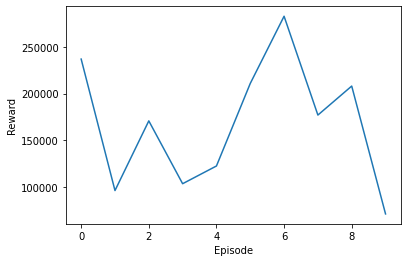

In [247]:
env = tradingEnv(df_train, 10, 1000000)
observation = env.reset()
print(observation.shape)
print(env.action_space)
Max_episode = 10
for idx in range(Max_episode):
  run_episode()
  print(idx)
env.render("plot episode rewards")

Streaming output truncated to the last 5000 lines.
price for reward: 6210.7
Step:  18741  Total Reward:  433108.330000001
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6214.89
Step:  18742  Total Reward:  434072.0300000012
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6213.7
Step:  18743  Total Reward:  433798.330000001
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6216.3
Step:  18744  Total Reward:  434396.330000001
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6216.3
Step:  18745  Total Reward:  434396.330000001
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6222.95
Step:  18746  Total Reward:  435925.830000001
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6219.41
Step:  18747  Total Reward:  435111.63000000105
torch.Size([10, 1, 256])
torch.Size([1, 1, 256])
price for reward: 6219.41
Step:  18748  Total Reward:  435111.63000000105
torch.Size([10, 1, 256])
torc

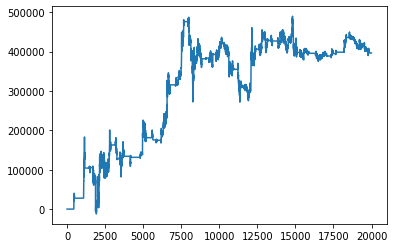

In [45]:
env_test = testEnv(df_test, 10, 1000000)
observation = env_test.reset()
print(observation.shape)
print(env_test.action_space)
action_list, reward_list = run_episode_test()
print(reward_list)
print(action_list)
plt.plot(reward_list)
plt.show()

5188.33
[0.0, -1563.123394232709, -1834.8871409489075, -2426.599695855868, -1353.036526203854, -1775.137664720649, -2064.2480335675646, -2438.1641106096795, -2438.1641106096795, -5283.010140064289, -3344.0432663304964, -3284.293790102005, -3332.478851576452, -3224.5443138735136, -701.5744950687513, -990.6848639157834, -393.19010163191706, -535.8178835964063, -801.7994229356991, -48.18506147444714, 171.5388188493671, 2336.0117802838795, 1790.556884392514, 871.1859114591498, 1605.5262483303668, 2767.7499310952844, 2445.8737204457866, 2073.8850458626403, 1081.272779487772, 2058.4658261907753, 2058.4658261907753, 2058.4658261907753, 2077.739850780461, 1526.5027475121897, 1536.139759807149, 1709.6059811153682, 1241.2471835833276, 903.9517532617319, 560.8741155632306, -1023.4507057182491, -292.9651737648528, -2044.9740089777624, -2187.601790942368, -7.709609835874289, 321.87621064973064, -2278.1897065143567, -849.9844844101463, -2567.3000753613887, -1846.4515557028353, -2706.073052407941, -1

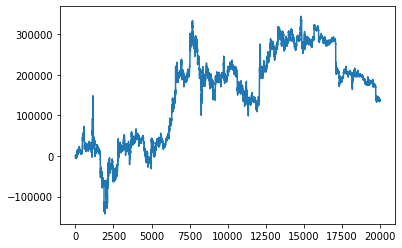

In [46]:
bitcoin = []
print(df_test['Close'].iloc[-1])
idx = -1
while True:
  bitcoin.append(1000000/df_test['Close'].iloc[-1]*df_test['Close'].iloc[idx] - 1000000)
  idx = idx -1
  if idx < -len(df_test['Close']):
    break
print(bitcoin)
plt.plot(bitcoin)
plt.show()

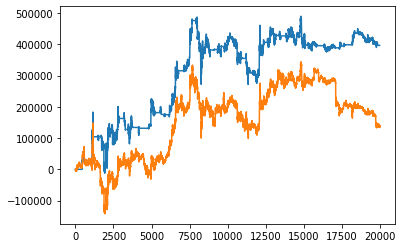

In [47]:
plt.plot(reward_list)
plt.plot(bitcoin)